[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/LinearRegression.ipynb)


# Linear Regression
Lets define a linear regression class, with the usual fit and predict methods.

In [11]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [12]:
class LinearRegression:
    def __init__(self, add_bias=True):
        """
        Initialize Linear Regression model.
        
        Parameters:
        add_bias: if True, adds an intercept term (bias/w_0) to the model
        """
        self.add_bias = add_bias
        pass
    
    def fit(self, x, y):
        """
        Fit the linear regression model by computing optimal weights.
        
        Parameters:
        x: input features, shape (N,) or (N, D) where N=samples, D=features
        y: target values, shape (N,)
        """
        # If x is 1D (shape: (N,)), convert to 2D column vector (shape: (N, 1))
        # x[:, None] adds a new axis, transforming (N,) -> (N, 1)
        if x.ndim == 1:
            x = x[:, None]
        
        N = x.shape[0]  # Number of samples
        
        if self.add_bias:
            # Add bias feature: append a column of ones to x
            # np.ones(N) creates array [1, 1, ..., 1] of length N
            # np.column_stack horizontally stacks x and the ones column
            # Result: if x is (N, D), new x is (N, D+1)
            x = np.column_stack([x, np.ones(N)])
        
        # Solve the least squares problem: minimize ||xw - y||^2
        # This is equivalent to: w = (x^T x)^-1 x^T y
        # np.linalg.lstsq is more numerically stable than computing inverse directly
        # [0] extracts the solution (lstsq returns multiple values)
        self.w = np.linalg.lstsq(x, y, rcond=None)[0]
        
        return self
    
    def predict(self, x):
        """
        Predict target values for input x using learned weights.
        
        Parameters:
        x: input features, shape (N,) or (N, D)
        
        Returns:
        yh: predicted values, shape (N,)
        """
        if self.add_bias:
            # Note: This assumes x has the same number of samples as training data
            # This will cause an error - should use x.shape[0] instead of N
            x = np.column_stack([x, np.ones(x.shape[0])])
        
        # Matrix multiplication: x @ w computes predictions
        # If x is (N, D+1) and w is (D+1,), result is (N,)
        yh = x @ self.w
        
        return yh


fit this linear model to toy data with $x \in \Re^1$ + a bias parameter

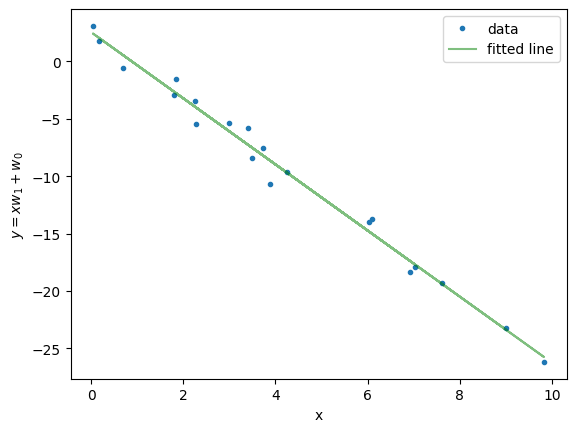

In [13]:
N = 20
# Generate N random x values uniformly distributed between 0 and 10
x = np.random.rand(N) * 10

# Create noisy linear data: y = -3x + 3 + noise
# True model: w_1 = -3 (slope), w_0 = 3 (intercept)
# np.random.randn(N) adds Gaussian noise with standard deviation 1
y = -3*x + 3 + 1*np.random.randn(N)

# Fit model and make predictions
model = LinearRegression()
yh = model.fit(x, y).predict(x)

# Plot the data and fitted line
plt.plot(x, y, '.', label='data')
plt.plot(x, yh, 'g-', alpha=.5, label='fitted line')
plt.xlabel('x')
plt.ylabel(r'$y=xw_1 + w_0$')
plt.legend()
plt.show()

## Weight Space
Next, for the same problem we plot *cost* as a function of model parameters (weights), and show the correspondence between the different weights having different costs and their fit. 

The `plot_contour` is a helper function we use for plotting the cost function moving forward. This gives a contour plot of `f` as a functions of two parameters that range between 

In [14]:
import itertools

def plot_contour(f, x1bound, x2bound, resolution, ax):
    """
    Plot contours of a 2D function f.
    
    Parameters:
    f: function that takes [x1, x2] and returns a scalar (the cost)
    x1bound: [min, max] for first parameter (e.g., w_0)
    x2bound: [min, max] for second parameter (e.g., w_1)
    resolution: number of grid points in each dimension
    ax: matplotlib axis to plot on
    """
    # Create 1D arrays of evenly spaced values for each parameter
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    
    # Create 2D grid: xg and yg are both (resolution x resolution) arrays
    # xg[i,j] contains the x1 value at grid point (i,j)
    # yg[i,j] contains the x2 value at grid point (i,j)
    xg, yg = np.meshgrid(x1range, x2range)
    
    # Initialize grid for function values (cost at each grid point)
    zg = np.zeros_like(xg)
    
    # Evaluate function f at each grid point
    # itertools.product gives all (i,j) combinations
    for i, j in itertools.product(range(resolution), range(resolution)):
        zg[i, j] = f([xg[i, j], yg[i, j]])
    
    # Draw contour lines: lines connecting points with equal cost
    ax.contour(xg, yg, zg, 100)
    
    return ax

Now let's define the cost function for linear regression example above, and visualize the cost and the fit of various models (parameters).

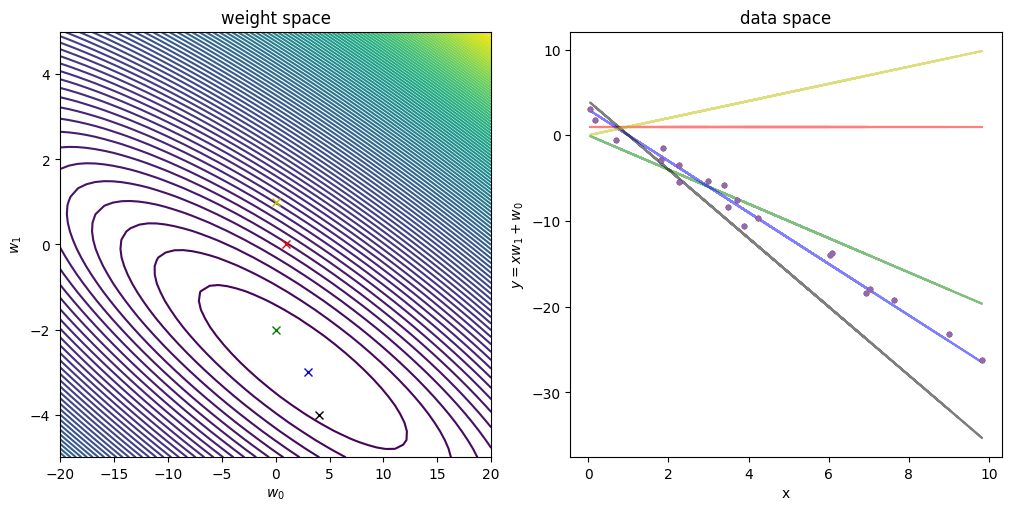

In [15]:
# Define the cost function (Mean Squared Error) as a function of weights w
# w[0] is the intercept (w_0), w[1] is the slope (w_1)
# Cost = (1/2) * average of squared errors
cost = lambda w: .5*np.mean((w[0] + w[1]*x - y)**2)

# List of different weight combinations to visualize
# Each tuple is (w_0, w_1) representing intercept and slope
model_list = [(1, 0), (0, -2), (3, -3), (4, -4), (0, 1)]

# Create side-by-side plots
fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(10, 5))

# Left plot: weight space showing cost landscape
plot_contour(cost, [-20, 20], [-5, 5], 50, axes[0])

colors = ['r', 'g', 'b', 'k', 'y']

# Plot each model in both weight space and data space
for i, w in enumerate(model_list):
    # Left plot: mark this weight combination with an 'x'
    axes[0].plot(w[0], w[1], 'x'+colors[i])
    
    # Right plot: show the data points
    axes[1].plot(x, y, '.')
    
    # Right plot: show the line for this weight combination
    # Line equation: y = w_0 + w_1 * x
    axes[1].plot(x, w[0] + w[1]*x, '-'+colors[i], alpha=.5)

# Label the plots
axes[0].set_xlabel(r'$w_0$')
axes[0].set_ylabel(r'$w_1$')
axes[0].set_title('weight space')
axes[1].set_xlabel('x')
axes[1].set_ylabel(r'$y=xw_1 + w_0$')
axes[1].set_title('data space')
plt.show()

In the plot above you see that the blue fit is better that others, it also has the lowest cost. 

# Nonlinear basis functions
Consider the toy dataset below. It is obvious that our attempt to model $y$ as a linear function of $x$ would produce a bad fit.
Let's try!

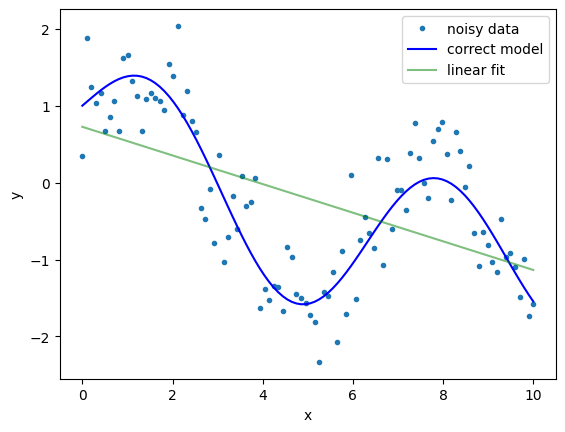

In [16]:
N = 100
# Create evenly spaced x values from 0 to 10
x = np.linspace(0, 10, N)

# Generate y from a nonlinear function (true underlying model)
yt = np.sin(x) + np.cos(x**.5)

# Add Gaussian noise to create observed y values
y = yt + .5*np.random.randn(N)

# Fit a linear model (this will be a poor fit for nonlinear data)
yh = model.fit(x, y).predict(x)

# Plot the data, true model, and linear fit
plt.plot(x, y, '.', label='noisy data')
plt.plot(x, yt, 'b-', label='correct model')
plt.plot(x, yh, 'g-', alpha=.5, label='linear fit')
plt.xlabel('x')
plt.ylabel(r'y')
plt.legend()
plt.show()

one way around this is to create new features, and create a better fit using them. Right now we only have a single feature 'x' and we have a poor fit.
We can create new features out of existing ones. In this case, we create features that are Gaussian-like functions of 'x', where each feature has a different mean. 
These are called non-linear bases, because each new feature is a non-linear function of the existing one.
Note that there are many other features that you can build to better fit this data. Below, we build ten such features with 10 different mean values.
By doing this our new design matrix (called `Phi` below) had 10 features (+1 intercept that is added in the `LinearRegression` class).
Below, let's plot these non-linear bases.

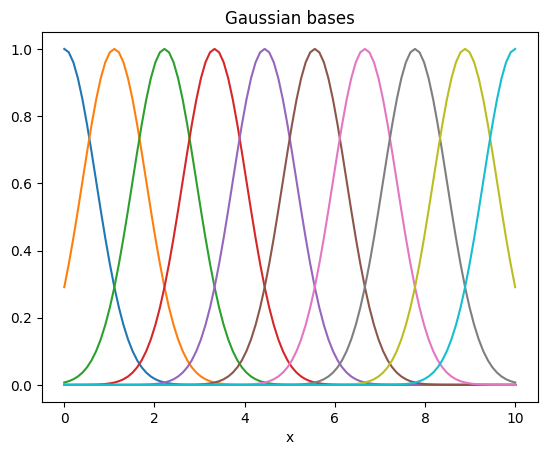

In [17]:
D = 10  # Number of basis functions

# Define Gaussian basis function
# For each x, this creates a bell-shaped curve centered at mu with width sigma
gaussian = lambda x, mu, sigma: np.exp(-((x - mu)/sigma)**2)

# Create D different centers (mu values) evenly spaced from 0 to 10
mu = np.linspace(0, 10, D)

# Create feature matrix phi using broadcasting
# x[:,None] converts x from shape (N,) to (N,1) - adds a column dimension
# mu[None,:] converts mu from shape (D,) to (1,D) - adds a row dimension
# Broadcasting: (N,1) and (1,D) -> (N,D)
# Result: phi[i,j] = gaussian(x[i], mu[j], 1)
# phi is (N, D) where each column is a Gaussian basis centered at different mu
phi = gaussian(x[:, None], mu[None, :], 1)

# Plot each basis function
for d in range(D):
    # phi[:,d] selects column d (all rows, column d) - this is the d-th basis function
    plt.plot(x, phi[:, d], '-')

plt.xlabel('x')
plt.title('Gaussian bases')
plt.show()

Now we predict `y` using `phi` as input features rather than `x`:

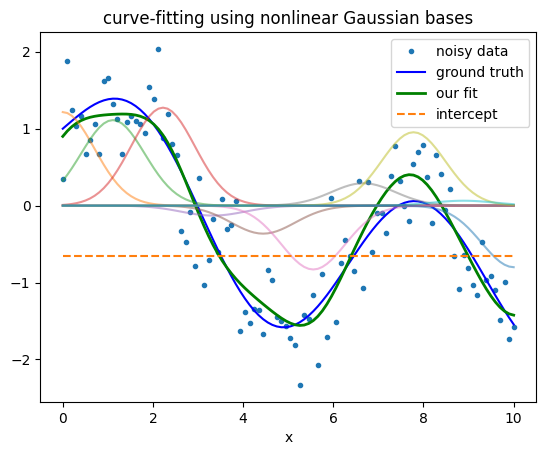

In [18]:
# Fit the model using nonlinear features (phi) instead of raw x
yh = model.fit(phi, y).predict(phi)

fig, ax = plt.subplots()

# Plot the data points
plt.plot(x, y, '.', label='noisy data')

# Plot the true underlying function
plt.plot(x, yt, 'b-', label='ground truth')

# Plot our fitted model (linear combination of Gaussian bases)
plt.plot(x, yh, 'g-', label='our fit', linewidth=2)

# Plot each weighted basis function to show how they combine
for d in range(D):
    # model.w[d] is the weight for the d-th basis function
    # phi[:,d] is the d-th basis function evaluated at all x values
    plt.plot(x, model.w[d]*phi[:, d], '-', alpha=.5)

# Plot the intercept (bias term) as a horizontal line
# model.w[-1] is the last weight (the bias term)
plt.plot(x, model.w[-1]*np.ones_like(y), label='intercept', linestyle='--')

plt.legend()
plt.xlabel('x')
plt.title('curve-fitting using nonlinear Gaussian bases')
plt.show()

Since our fit is a linear combination of these bases, you can see that by suming these weighted bases and the intercept, we recover our fit (green curve). Note that here we could plot all features and our prediction for $D=10$ only because all of features are functions of $x$. In general, when we have D features, we need to use a $D+1$ dimensional plot (+1 is for the label $y$). 

We can simply replace the bases above with sigmoid bases and fit the data again.

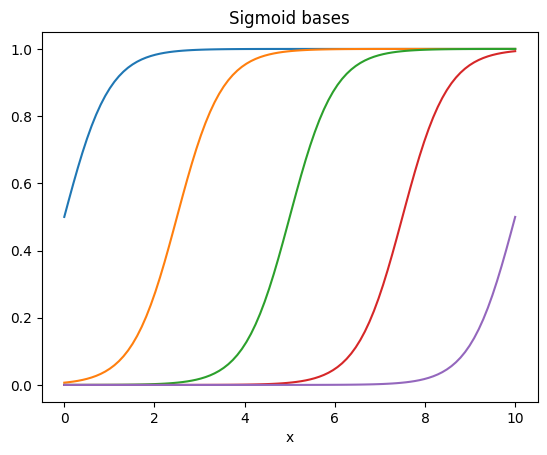

In [19]:
D = 5  # Number of sigmoid basis functions

# Define sigmoid basis function
# Creates an S-shaped curve that transitions from 0 to 1 around mu
sigmoid = lambda x, mu, s: 1/(1 + np.exp(-(x - mu)/s))

# Create D different centers evenly spaced from 0 to 10
mu = np.linspace(0, 10, D)

# Create feature matrix using sigmoid bases
# Same broadcasting pattern as with Gaussian bases:
# x[:,None] is (N,1), mu[None,:] is (1,D), result is (N,D)
phi = sigmoid(x[:, None], mu[None, :], .5)

# Plot each sigmoid basis function
for d in range(D):
    plt.plot(x, phi[:, d], '-')

plt.xlabel('x')
plt.title('Sigmoid bases')
plt.show()

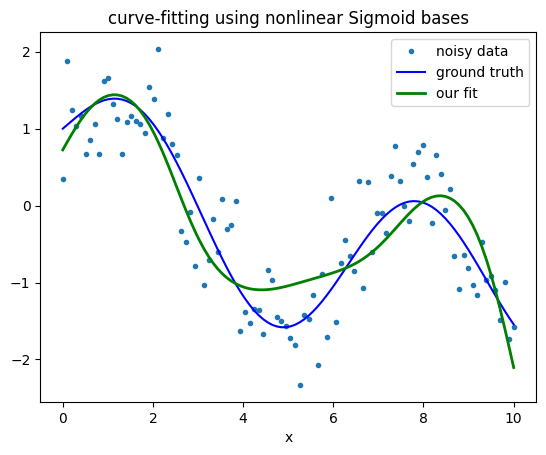

In [20]:
# Fit the model using sigmoid basis functions
yh = model.fit(phi, y).predict(phi)

fig, ax = plt.subplots()

# Plot the data and fits
plt.plot(x, y, '.', label='noisy data')
plt.plot(x, yt, 'b-', label='ground truth')
plt.plot(x, yh, 'g-', label='our fit', linewidth=2)

# Optionally plot individual weighted basis functions (commented out for clarity)
#for d in range(D):
#    plt.plot(x, model.w[d]*phi[:,d], '-', alpha=.5)
#plt.plot(x, model.w[-1]*np.ones_like(y), label='intercept')

plt.legend()
plt.xlabel('x')
plt.title('curve-fitting using nonlinear Sigmoid bases')
plt.show()